<a href="https://colab.research.google.com/github/nedokormysh/eda_and_dev_tools/blob/pipeline/Pipeline_abalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Условие.

В рамках этой части задания ответьте в ноутбуке на следующие вопросы:

Построение моделей на числовых признаках (минимум - NB и kNN, максимум - любые) с параметрами по умолчанию, вычисление метрик + комментарий о качестве моделей (1 балл).

Подбор гиперпараметров у каждой из моделей (только на числовых признаках) при помощи GridSearchCV + вычисление метрик для лучших найденных моделей + текстовый комментарий (3 балла).

Добавление категориальных признаков в лучшую модель, обучение модели и заново подбор ее гиперпараметров + вычисление метрик + текстовый комментарий (2 балла).

Построение Explainer Dashboard и сохранение файла с ним на GitHub (1 балл)

Анализ модели в Explainer Dashboard (выводы пишем в том же Jupyter Notebook):
* какие факторы наиболее важны в среднем для получения прогноза? (1 балл)
* какие значения метрик получились и что это значит? (1 балл)
* анализ 2-3 индивидуальных прогнозов с комментарием (1 балл)

# Подбор гиперпараметров у каждой из моделей

(только на числовых признаках) при помощи GridSearchCV + вычисление метрик для лучших найденных моделей + текстовый комментарий (3 балла).

In [1]:
!pip install catboost -q
!pip install explainerdashboard -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 970.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Type

# Метрика качества
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

# Разделение датасета
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate

# Модели
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

from explainerdashboard import RegressionExplainer, ExplainerDashboard

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
ABALONE_DATASET_PATH = 'https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/abalone.csv'

# Обработка данных.



## Оптимизация памяти.

In [4]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file) -> pd.DataFrame:
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [5]:
df = import_data(ABALONE_DATASET_PATH)
df.sample(5)

Memory usage of dataframe is 0.29 MB
Memory usage after optimization is: 0.06 MB
Decreased by 77.7%


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
3016,I,0.435059,0.334961,0.104980,0.353516,0.156006,0.049988,0.113525,7
3329,F,0.544922,0.435059,0.150024,0.685547,0.290527,0.145020,0.224976,10
707,F,0.344971,0.260010,0.090027,0.207031,0.077515,0.043488,0.076477,10
3676,F,0.600098,0.500000,0.160034,1.122070,0.509277,0.256104,0.309082,10
1639,I,0.575195,0.449951,0.135010,0.807129,0.361572,0.176025,0.253906,10


In [6]:
df.columns = df.columns.str.replace(' ','_')

In [7]:
cat_features = ['Sex']
targets = ['Rings']
num_features = [i for i in df.columns if (i not in cat_features and i not in targets)]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['Sex'], amount = 1
num_features: ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight'], amount = 7
targets: ['Rings'], amount = 1


In [8]:
df['Sex'].astype('category');

## Класс препроцессинга.

In [9]:
class DataPreprocessing():
    """Подготовка исходных данных"""

    def __init__(self) -> None:
        """Параметры класса"""
        self.medians = None
        self.modes = None

    def fit(self, data: pd.DataFrame) -> None:
        """Сохранение статистик"""
        # Расчет статистик
        self.medians = data.median()
        self.modes = data.mode()

    def transform(self, data: pd.DataFrame, y: pd.Series) -> tuple([pd.DataFrame, pd.Series]):

        """Трансформация данных"""

        data = pd.concat([data, y], axis=1)

        # удаление строк с нулевым значением высоты
        data = data[data['Height'] != 0]

        # удаление строк, где вес частей меньше общего веса
        data = data[~((data['Whole_weight'] <= data['Shucked_weight']) |
                      (data['Whole_weight'] <= data['Viscera_weight']) |
                      (data['Whole_weight'] <= data['Shell_weight']))]

        # обработка пропущенных значений
        data.fillna(self.medians, inplace=True)

        # замена значений признака пола с f на F
        data['Sex'] = data['Sex'].replace('f', 'F')

        y = data['Rings']
        X = data.drop('Rings', axis=1)

        return X, y

In [10]:
y = df['Rings']
X = df.drop(['Rings'], axis=1)

Выделим минимальную часть данных на тестовые данные. Берём минимум, т.к. датасет и так не слишком большой. Попытаемся не допустить утечку данных.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False, random_state=7575)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3759, 8), (418, 8), (3759,), (418,))

Т.к. в дальнейшем будем использовать кросс-валидационных подход, то не будем отдельно выделять валидационную выборку для подбора гиперпараметров.

In [12]:
# X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.20, shuffle=True, random_state=7575)

# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [13]:
# объявляем объект препроцессор и получаем статистические характеристики по обучающей выборке
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

# применим преоборазования для наших данных
X_train, y_train = preprocessor.transform(X_train, y_train)
# X_val, y_val  = preprocessor.transform(X_val, y_val)
X_test, y_test = preprocessor.transform(X_test, y_test)

<ipython-input-9-7893ac69ce36>:12: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


## Класс решения

Класс, в котором собраны функции для решения задачи.
* model_implementation() - самое простое применения алгоритма к разделению train-test
* cross_val() - кросс-валидация. Применяем ко всему датасету
* grid_search_implementation() - перебор по сетке параметров

В классе рассчитываются метрики RMSE, MAPE. Для числовых признаков используется нормализация, категориальные кодируем ohe.

In [14]:
# определим кастомную функцию расчёта MAPE
def NMAPE(y_true, y_pred):
    return (1 - np.mean(np.abs((y_true - y_pred) / y_true)) * 100) / 100

# создадим скорер
nmape_scorer = make_scorer(NMAPE)

In [15]:
class Solver():
    '''
    Класс для решения различных частей задания.

    Параметры.
    algorithm: Type
       алгоритм, который будет использован для создания модели
    X_train: pd.DataFrame
       фичи обучающей выборки
    y_train: pd.Series
       таргет обучающей выборки
    X_test: pd.DataFrame, optional
       фичи тестовой выборки. Если тестовой выборки не указано,
       то работа будет вестись только с обучающей выборкой
    y_test: pd.Series, optional
       таргет обучающей выборки. Если тестовой выборки не указано,
       то работа будет вестись только с обучающей выборкой
    condition: str = 'по умолчанию', optional
       просто текст, для вывода результата
    cat_features: bool = False, optional
       булева переменная для работы с категориальными признаками
       если False, то работаем только с числовыми, нормализируем данные
       если True, помимо нормализации числовых признаков, кодируем категориальные
       при помощи one-hot-encoding
    grid: dict = None, optional
        словарь, с параметрами, которые хотим перебирать в GridSearchCV,
    verbose: bool = False, optional
        булева переменная для отображения применяемого пайплайна
    '''
    def __init__(self,
                 algorithm: Type,
                 X_train: pd.DataFrame,
                 y_train: pd.Series,
                 X_test: pd.DataFrame = None,
                 y_test: pd.Series = None,
                 condition: str = 'по умолчанию',
                 cat_features: bool = False,
                 grid: dict = None,
                 verbose: bool = False,):

        self.algorithm = algorithm,
        self.X_train = X_train,
        self.y_train = y_train,
        self.X_test = X_test,
        self.y_test = y_test,
        self.condition = condition,
        self.cat_features = cat_features
        self.grid = grid
        self.verbose = verbose

        num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
        cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder())])


        if cat_features:
            self.features = 'числовые + категориальные'
            cat_feat = ['Sex']
            num_feats = X_train.columns.drop('Sex').values
            data_transformer = ColumnTransformer(transformers=
                                        [('numerical', num_transformer, num_feats),
                                         ('categorical', cat_transformer, cat_feat)])
        else:
            self.features = 'числовые'
            num_feats = X_train.columns.values
            data_transformer = ColumnTransformer(transformers=
                                        [('numerical', num_transformer, num_feats)])


        if self.algorithm[0].__name__ == 'CatBoostRegressor':
            model = self.algorithm[0](verbose=0)
        else:
            model = self.algorithm[0]()

        self.model = make_pipeline(data_transformer, model)

        if self.verbose:
            print(f'{self.model}')


    def __repr__(self):
        return f'Класс решешия. Модель = {self.algorithm}, условие: {self.condition},\
        используемые фичи {self.features}'

    def result(self,
               rmse: float,
               mape: float,
               rmse_std: float = None,
               mape_std: float = None) -> pd.DataFrame:

        '''
        Функция для вывода результатов
        '''

        if (rmse_std is not None) & (mape_std is not None):
            di = {'model': [self.algorithm[0].__name__],
                  'condition': [self.condition][0],
                  'features': [self.features],
                  'RMSE': [rmse],
                  'RMSE_std': [rmse_std],
                  'MAPE': [mape],
                  'MAPE_std': [mape_std],
                  }
        else:
            di = {'model': [self.algorithm[0].__name__],
                  'condition': [self.condition][0],
                  'features': [self.features],
                  'RMSE': [rmse],
                  'MAPE': [mape]}

        res = pd.DataFrame(di)
        return res

    @staticmethod
    def get_metrics_score(y_pred, y_test):
        '''
        Функция подсчёта метрик
        '''
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        print(f'Ошибка на тестовой выборке: RMSE = {rmse}, MAPE = {mape}')

        return rmse, mape

    def model_implementation(self) -> pd.DataFrame:
        '''
        Применение модели для единичного разбиения на train и test
        '''
        self.model.fit(self.X_train[0], self.y_train[0])
        y_pred = self.model.predict(self.X_test[0])

        rmse, mape = getattr(self, 'get_metrics_score')(y_pred, y_test)

        res = self.result(rmse, mape)
        return res

    def cross_val(self):
        '''
        Применение модели для кросс валидации
        '''
        di_res = cross_validate(self.model,
                       self.X_train[0],
                       self.y_train[0],
                       scoring={'RMSE': 'neg_mean_squared_error',
                                'MAPE': nmape_scorer},
                       cv=5,
                       n_jobs=-1)

        rmse = np.sqrt(np.abs(di_res['test_RMSE']))
        rmse_std = np.std(rmse)
        rmse = np.mean(rmse)
        mape = np.abs(di_res['test_MAPE'])
        mape_std = np.std(mape)
        mape = np.mean(mape)

        res = self.result(rmse, mape, rmse_std, mape_std)
        print(f'Ошибка на тестовой выборке: RMSE = {rmse} \u00B1 {rmse_std}, MAPE = {mape} \u00B1 {mape_std}')
        return res

    def grid_search_implementation(self):
        gs = GridSearchCV(self.model,
                          self.grid,
                          scoring='neg_mean_squared_error',
                          cv=3,
                          n_jobs=-1,
                          verbose=2)
        gs.fit(self.X_train[0], self.y_train[0])

        model = gs.best_estimator_
        y_pred = model.predict(self.X_test[0])
        rmse, mape = getattr(self, 'get_metrics_score')(y_pred, y_test)
        res = self.result(rmse, mape)
        return res, model

# Построение моделей на числовых признаках

(минимум - NB и kNN, максимум - любые) с параметрами по умолчанию, вычисление метрик + комментарий о качестве моделей.

Не совсем уверен, что нельзя здесь решать задачу многолассовой классификации, но всё таки нам нужно получить число, поэтому будем решать задачу регрессии.

Naive Bayes можно применить к данной задаче, но, насколько я понимаю, фактически мы получим логистическую регрессию. Как указал выше, возможно такой подход и будет работать, но всё таки мы хотим решать задачу регрессии, поэтому не будем использовать данную модель. Вместо неё рассмотрим пару других моделей.

 Рассмотрим пару метрик. В принципе, считаю, что метрики MSE должно хватать.

* RMSE - Возьмём RMSE, чтобы наш показатель эффективности совпадал с размерностью исходных данных. В наших данных не так много предполагаемых выбросов, а потому ошибки на выбросах не будут скрывать ошибки на множестве объектов. Следовательно можем использовать RMSE, и не испольватьвать, например, MAE.

Вообще для более честного применения, насколько я понимаю, необходимо было также нормализовывать целевую переменную. Но в данной работе этого не делал. Кроме того, в принципе, наши числовые данные были отчасти уже отчасти нормализованы делением на 200. И некоторые алгоритмы, которые применялись в данной работе не требовательны к масштабированию.

* MAPE - также рассмотрим метрику для оценки относительной ошибки на объектах. Предположим, что вдруг нам нужно лучше предсказывать возраст более редких

In [16]:
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]

## KNN regression (без параметров)

In [17]:
solver = Solver(KNeighborsRegressor, X_train_num, y_train, X_test_num, y_test, verbose=True)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight'], dtype=object))])),
                ('kneighborsregressor', KNeighborsRegressor())])


In [18]:
df_results = pd.DataFrame()

res = solver.model_implementation()
df_results = pd.concat([df_results, res])
# df_results

Ошибка на тестовой выборке: RMSE = 2.0827255708223573, MAPE = 0.15156585996614283


## Linear regression (без параметров)

In [19]:
solver = Solver(LinearRegression, X_train_num, y_train, X_test_num, y_test)

res = solver.model_implementation()
df_results = pd.concat([df_results, res])

Ошибка на тестовой выборке: RMSE = 2.09375, MAPE = 0.1639825145781727


## Random forest (без параметров)

In [20]:
solver = Solver(RandomForestRegressor, X_train_num, y_train, X_test_num, y_test)

res = solver.model_implementation()
df_results = pd.concat([df_results, res])

Ошибка на тестовой выборке: RMSE = 2.0648033102046632, MAPE = 0.15961951843096184


## CatBoost (без параметров)

In [21]:
solver = Solver(CatBoostRegressor, X_train_num, y_train, X_test_num, y_test)

res = solver.model_implementation()
df_results = pd.concat([df_results, res])

Ошибка на тестовой выборке: RMSE = 2.0192628695136188, MAPE = 0.15382006369241913


## Промежуточные результаты 1

In [22]:
df_results.reset_index().drop('index', axis=1)

,model,condition,features,RMSE,MAPE
0,KNeighborsRegressor,по умолчанию,числовые,2.082726,0.151566
1,LinearRegression,по умолчанию,числовые,2.093750,0.163983
2,RandomForestRegressor,по умолчанию,числовые,2.064803,0.159620
3,CatBoostRegressor,по умолчанию,числовые,2.019263,0.153820


* Рассмотрели 4 модели. Использовали только числовые признаки. Параметры у моделей по умолчанию.

* Достаточно ожидаемо оказалось, что catboost выдал лучшие результаты по обеим метрикам, среди всех моделей.

* RMSE метрика ничем не ограничена, поэтому особо сравнивать её можно только между моделями. По MAPE метрике в принципе, результаты достаточно хорошие.

* Из интересных результатов: линейная регрессия по RMSE оказалась лучше, чем KNN, но по MAPE хуже. Переходом от абсолютных ошибок на объекте к относительным мы делаем объекты в тестовой выборке равнозначными. Т.е. в среднем мы для линейной регрессии получаии ошибки меньше, чем в KNN. Но в каких-то объектах мы допускали в модели линейной регрессии в относительных величинах ошибку больше, чем в KNN.

## Cross_val

Это всё мы пременяли пока для единичного разбиения данных на обучающую и тестовую выборки.

Применим кросс_валидацию. Для этого возьмём полностью наши данные без разбиения.

In [23]:
# объявляем объект препроцессор и получаем статистические метрики по ним.
preprocessor = DataPreprocessing()
preprocessor.fit(X)

# применим преоборазования для наших данных
X_prep, y_prep = preprocessor.transform(X, y)
X_prep_num = X_prep[num_features]

<ipython-input-9-7893ac69ce36>:12: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


### KNN regression

In [24]:
solver = Solver(KNeighborsRegressor, X_prep_num, y_prep, condition='кросс-валидация')
res = solver.cross_val()

df_results = pd.concat([df_results, res])

Ошибка на тестовой выборке: RMSE = 2.335616866062467 ± 0.5566565209997978, MAPE = 0.1577852075635639 ± 0.016814673776356974


### Linear regression

In [25]:
solver = Solver(LinearRegression, X_prep_num, y_prep, condition='кросс-валидация')
res = solver.cross_val()

df_results = pd.concat([df_results, res])

Ошибка на тестовой выборке: RMSE = 2.3304622761128257 ± 0.5396398841959577, MAPE = 0.16307128906249999 ± 0.012247588874041251


### Random forest

In [26]:
solver = Solver(RandomForestRegressor, X_prep_num, y_prep, condition='кросс-валидация')
res = solver.cross_val()

df_results = pd.concat([df_results, res])

Ошибка на тестовой выборке: RMSE = 2.2208367648830265 ± 0.4956367600819742, MAPE = 0.15263489213036346 ± 0.012290158857309096


### CatBoost

In [27]:
solver = Solver(CatBoostRegressor, X_prep_num, y_prep, condition='кросс-валидация')
res = solver.cross_val()

df_results = pd.concat([df_results, res])

Ошибка на тестовой выборке: RMSE = 2.194783840081244 ± 0.5259898780340972, MAPE = 0.148315908108341 ± 0.01347799910747326


###  Промежуточные результаты 2

In [28]:
df_results.reset_index().drop('index', axis=1)

,model,condition,features,RMSE,MAPE,RMSE_std,MAPE_std
0,KNeighborsRegressor,по умолчанию,числовые,2.082726,0.151566,NaN,NaN
1,LinearRegression,по умолчанию,числовые,2.093750,0.163983,NaN,NaN
2,RandomForestRegressor,по умолчанию,числовые,2.064803,0.159620,NaN,NaN
3,CatBoostRegressor,по умолчанию,числовые,2.019263,0.153820,NaN,NaN
4,KNeighborsRegressor,кросс-валидация,числовые,2.335617,0.157785,0.556657,0.016815
5,LinearRegression,кросс-валидация,числовые,2.330462,0.163071,0.539640,0.012248
6,RandomForestRegressor,кросс-валидация,числовые,2.220837,0.152635,0.495637,0.012290
7,CatBoostRegressor,кросс-валидация,числовые,2.194784,0.148316,0.525990,0.013478


На кросс-валидации Catboost всё равно показывает лучшие результаты по обеим метрикам.

При этом Random Forest даёт незначительно, но более стабильные результаты.

# Подбор гиперпараметров у каждой из моделей

(только на числовых признаках) при помощи GridSearchCV + вычисление метрик для лучших найденных моделей + текстовый комментарий (3 балла).

## KNN regression

In [29]:
params = {'kneighborsregressor__n_neighbors' : np.arange(2, 20, 2),
          'kneighborsregressor__weights' : ['uniform', 'distance'],
          'kneighborsregressor__p' : [1, 2]
          }

solver = Solver(KNeighborsRegressor,
                X_train_num,
                y_train,
                X_test_num,
                y_test,
                condition='перебор по сетке',
                grid=params)

res, _ = solver.grid_search_implementation()

df_results = pd.concat([df_results, res])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Ошибка на тестовой выборке: RMSE = 1.9505672499464721, MAPE = 0.14697730015008426


## Linear regression

У линейной регрессии фактически нечего перебирать, поэтому пропустим этот этап.

## Random Forest

In [30]:
params = {'randomforestregressor__n_estimators' : np.arange(100, 500, 100),
          'randomforestregressor__max_depth': np.arange(2, 8, 2),
          'randomforestregressor__min_samples_leaf' : [.5, .8],
          'randomforestregressor__max_features' : [.2, .5, .8]
          }

solver = Solver(RandomForestRegressor,
                X_train_num,
                y_train,
                X_test_num,
                y_test,
                condition='перебор по сетке',
                grid=params)

res, _ = solver.grid_search_implementation()

df_results = pd.concat([df_results, res])

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Ошибка на тестовой выборке: RMSE = 2.7870754846198866, MAPE = 0.2454324863267408


## CatBoost

In [31]:
params = {'catboostregressor__depth' : np.arange(2, 8, 2),
          'catboostregressor__learning_rate': [.01, .1],
          'catboostregressor__min_data_in_leaf': np.arange(100, 500, 100),
          'catboostregressor__l2_leaf_reg' : np.arange(2, 8, 2)
          }

solver = Solver(CatBoostRegressor,
                X_train_num,
                y_train,
                X_test_num,
                y_test,
                condition='перебор по сетке',
                grid=params)

res, _ = solver.grid_search_implementation()

df_results = pd.concat([df_results, res])

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Ошибка на тестовой выборке: RMSE = 1.9767985076218662, MAPE = 0.1521162147374761


## Промежуточные результаты 3

In [32]:
df_results.reset_index().drop(['index', 'RMSE_std', 'MAPE_std'], axis=1).iloc[8: 11]

,model,condition,features,RMSE,MAPE
8,KNeighborsRegressor,перебор по сетке,числовые,1.950567,0.146977
9,RandomForestRegressor,перебор по сетке,числовые,2.787075,0.245432
10,CatBoostRegressor,перебор по сетке,числовые,1.976799,0.152116


Результаты улучшились по RMSE. (GridSearch проводился по этому параметру). При этом лучшие результаты удалось получить в методе KNN. Предполагаю, что возможно выжать из CatBoost лучшие результаты, но при этом, если использовать только перебор по сетке это занимает слишком большое время. И поэтому не рассматривались все параметры, которые можно было бы проверить. А также шаг сетки был выбран слишком большой.

# Добавление категориальных признаков
в лучшую модель, обучение модели и заново подбор ее гиперпараметров + вычисление метрик + текстовый комментарий (2 балла).

Если верно уловил задание, то по результатам вышеперечисленных пунктов мы определили, что лучшая результаты нам демонстрирует модель на основе KNN regressor.

Добавим в неё категориальные признаки и посмотрим улучшился ли результат.

Но всё таки сравним

In [33]:
params = {'kneighborsregressor__n_neighbors' : np.arange(2, 20, 2),
          'kneighborsregressor__weights' : ['uniform', 'distance'],
          'kneighborsregressor__p' : [1, 2]
          }

solver = Solver(KNeighborsRegressor,
                X_train,
                y_train,
                X_test,
                y_test,
                condition='перебор по сетке',
                grid=params,
                cat_features=True,
                verbose=True)

res, best_model = solver.grid_search_implementation()

df_results = pd.concat([df_results, res])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight'], dtype=object)),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('kneighborsregressor', KNeighborsRegressor())])
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Ошибка на тестовой выборке: RMSE = 1.9656572232424931, MAPE = 0.14499089383238348


In [34]:
params = {'catboostregressor__depth' : np.arange(2, 8, 3),
          'catboostregressor__learning_rate': [.01, .1],
          'catboostregressor__min_data_in_leaf': np.arange(100, 500, 100),
          'catboostregressor__l2_leaf_reg' : np.arange(2, 8, 3)
          }

solver = Solver(CatBoostRegressor,
                X_train,
                y_train,
                X_test,
                y_test,
                condition='перебор по сетке',
                grid=params,
                cat_features=True)

res, _ = solver.grid_search_implementation()

df_results = pd.concat([df_results, res])

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Ошибка на тестовой выборке: RMSE = 1.9666135652849104, MAPE = 0.14944665472798885


In [35]:
df_results.reset_index().drop(['index', 'RMSE_std', 'MAPE_std'], axis=1).iloc[11: 13]

,model,condition,features,RMSE,MAPE
11,KNeighborsRegressor,перебор по сетке,числовые + категориальные,1.965657,0.144991
12,CatBoostRegressor,перебор по сетке,числовые + категориальные,1.966614,0.149447


Результаты оказались достаточно близки. Продолжим работу с KNN.

Сохраним получившуюся модель.

In [36]:
import pickle

 # Save to file in the current working directory
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_model, file)

 # Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

# Построение Explainer Dashboard
 и сохранение файла с ним на GitHub (1 балл)

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [38]:
explainer = RegressionExplainer(pickle_model, X_test, y_test, permutation_metric='rmse')

splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Generating self.shap_explainer = shap.KernelExplainer(model, X)...


In [39]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.


  0%|          | 0/417 [00:00<?, ?it/s]

Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [40]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>

In [41]:
db.save_html("dashboard.html")

# Анализ модели в Explainer Dashboard (выводы пишем в том же Jupyter Notebook):


## какие факторы наиболее важны в среднем для получения прогноза?


По итоговый возраст по метрике shap в среднем численно дают метрики: shell_weight, shucked_weight, height, whole_weight. Остальные метрики также вносят свой вклад, но меньше. И пол мужской и женский практически не влияют.

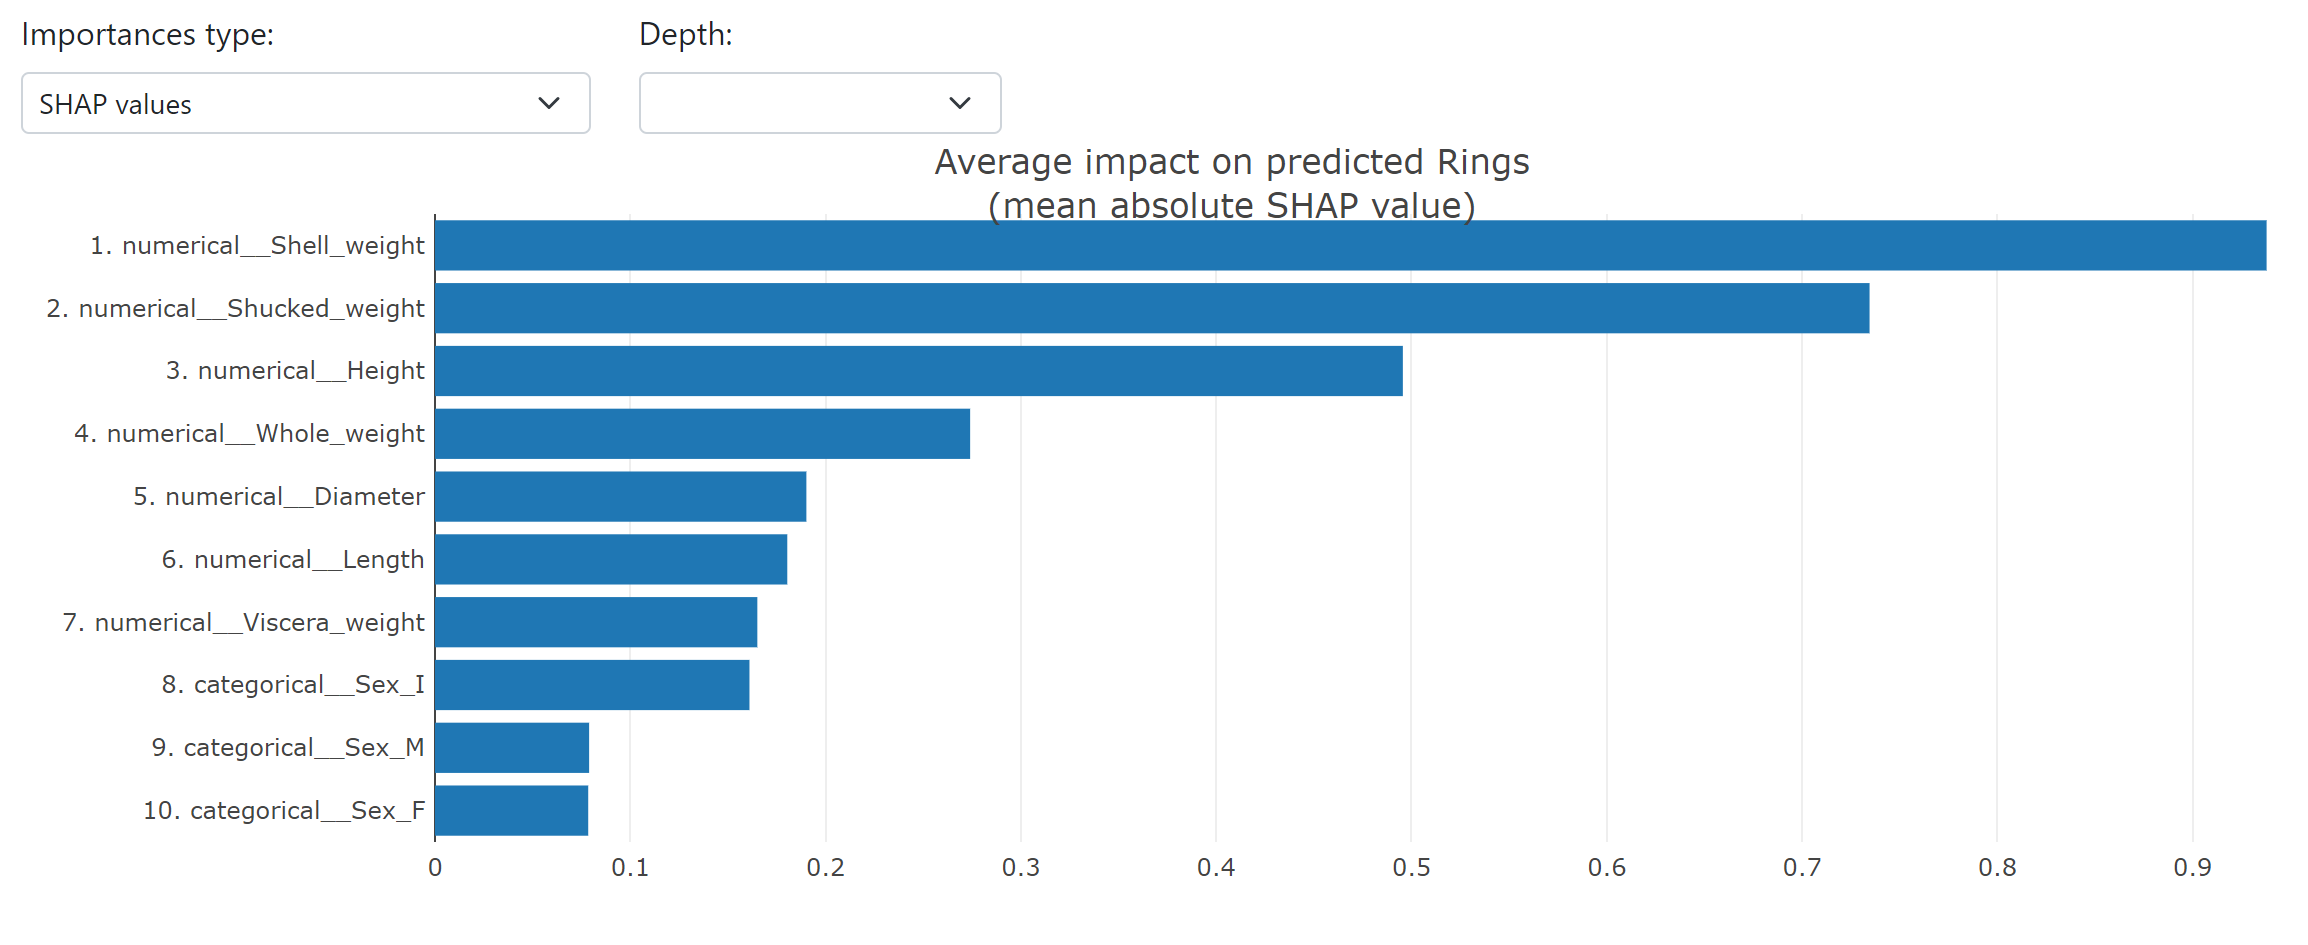

## какие значения метрик получились и что это значит?


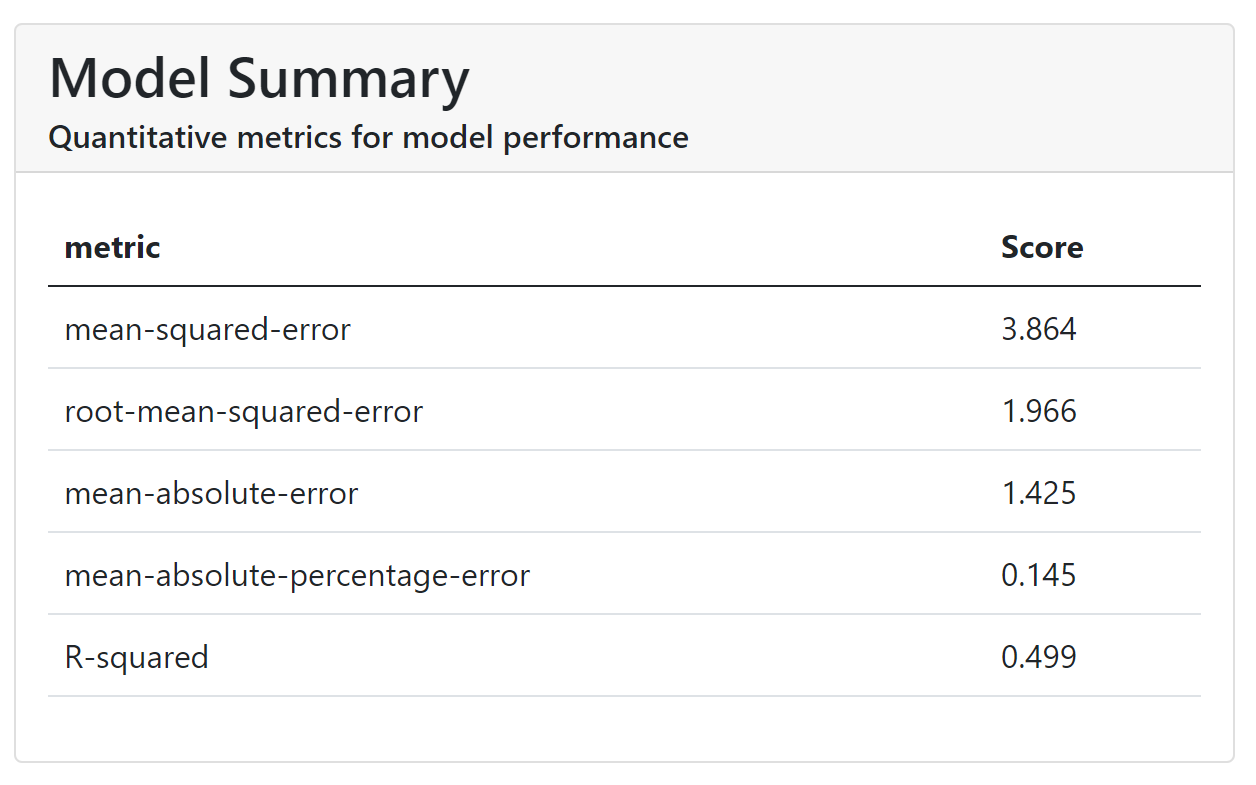

Интерпретация выбранных метрик, насколько я понимаю, несколько сложна. В принципе, значение RMSE достаточно велико относительно среднего значения. Но изначально было лучше нормализовать целевую переменную. Также возможно мы получаем float значения, а не int, как в целевой переменной. Возможно это даёт свой вклад в ошибку. Вероятно можно выбирать порог округления.

Не совсем ожидал, что метрика $R^2$ будет достаточно плохой.

In [44]:
1.966 / y_test.mean() * 100

20.172785433070867

## анализ 2-3 индивидуальных прогнозов с комментарием

### 4138

Предсказанное значние - 9.985, реальное - 11.000. Ошибка:	1.015. достаточно велико расхождение.

На прогноз для данного объекта по большей части влияют различные веса и высота. При этом пол практически никак не влияет.

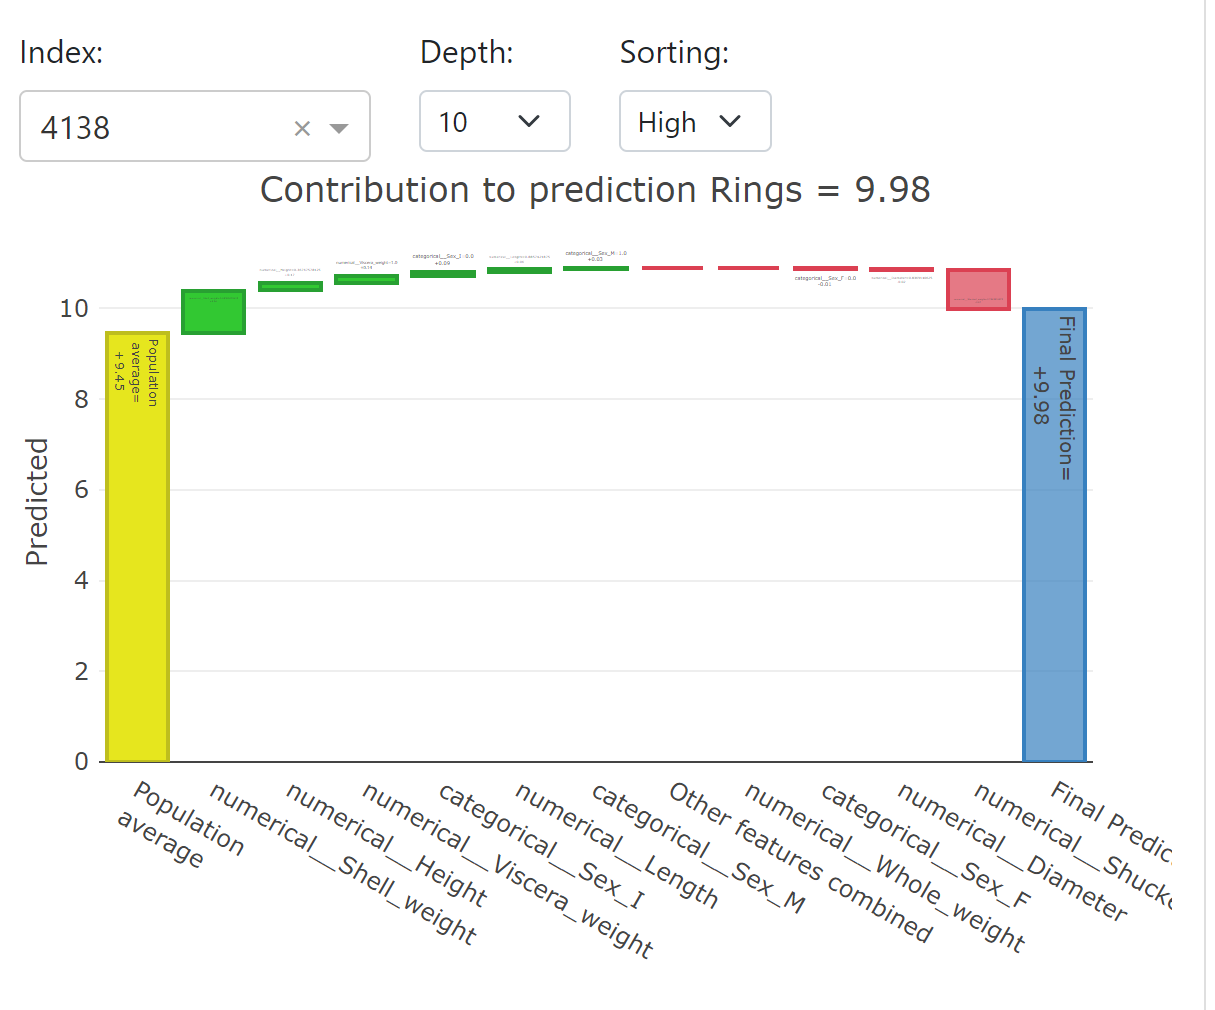

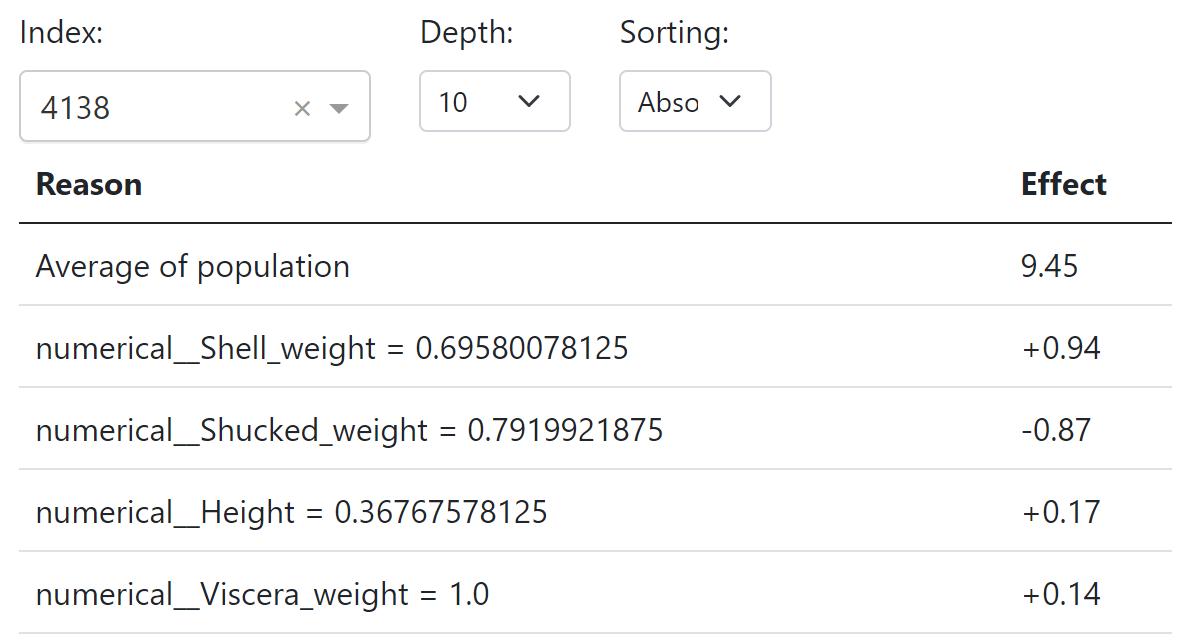

### 4126

Предсказанное значение - 11.195, реальное - 11.000. Ошибка не столь велика.

На прогноз для данного объекта по большей части влияют различные веса, но в данном объекте диаметр и пол более значимы, чем высота.

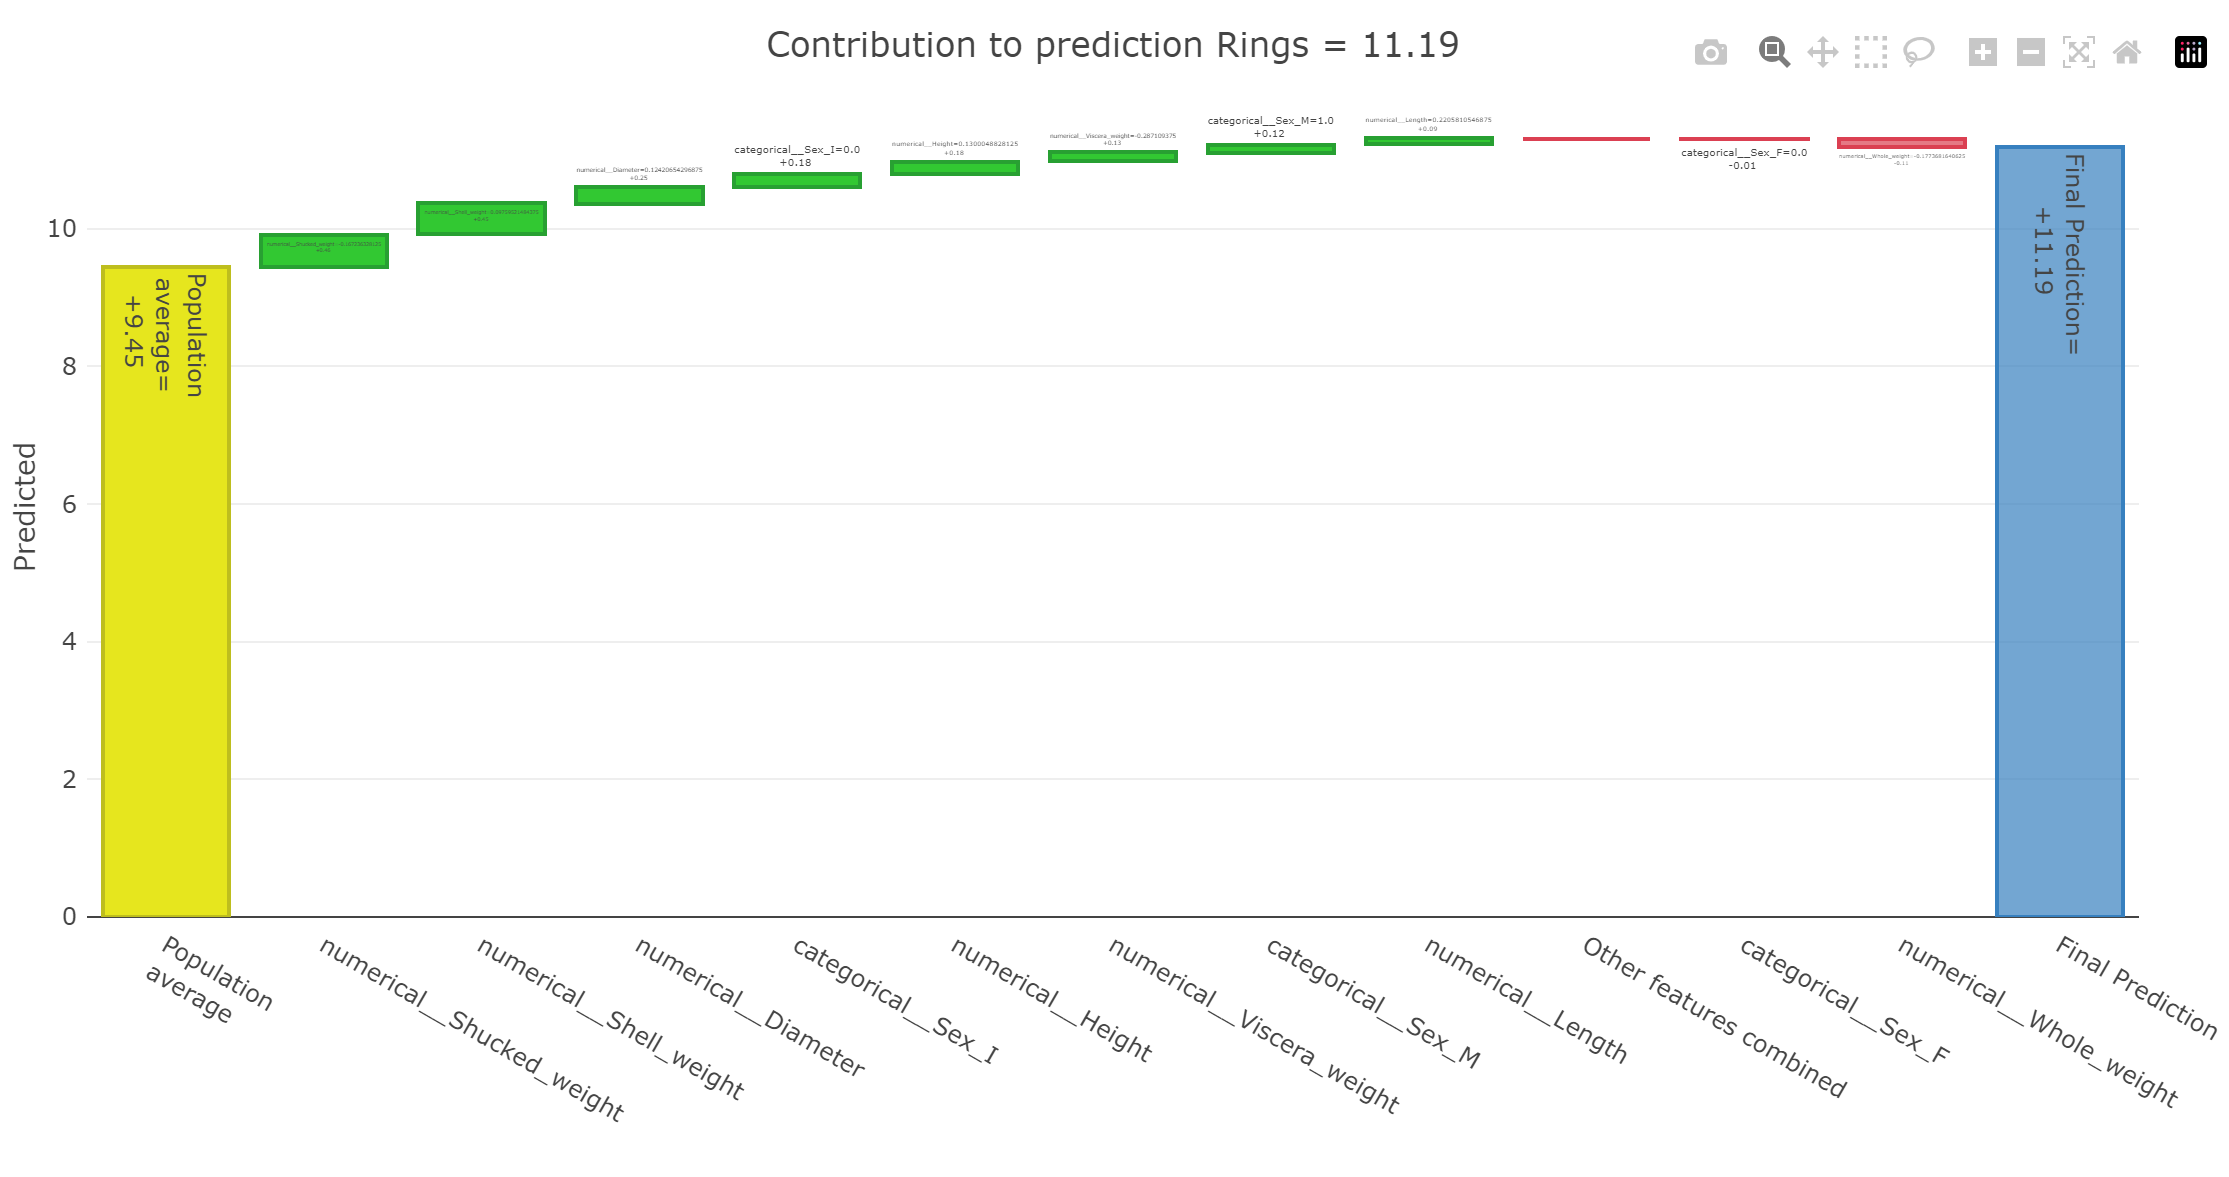

Важные признаки для данного объекта.


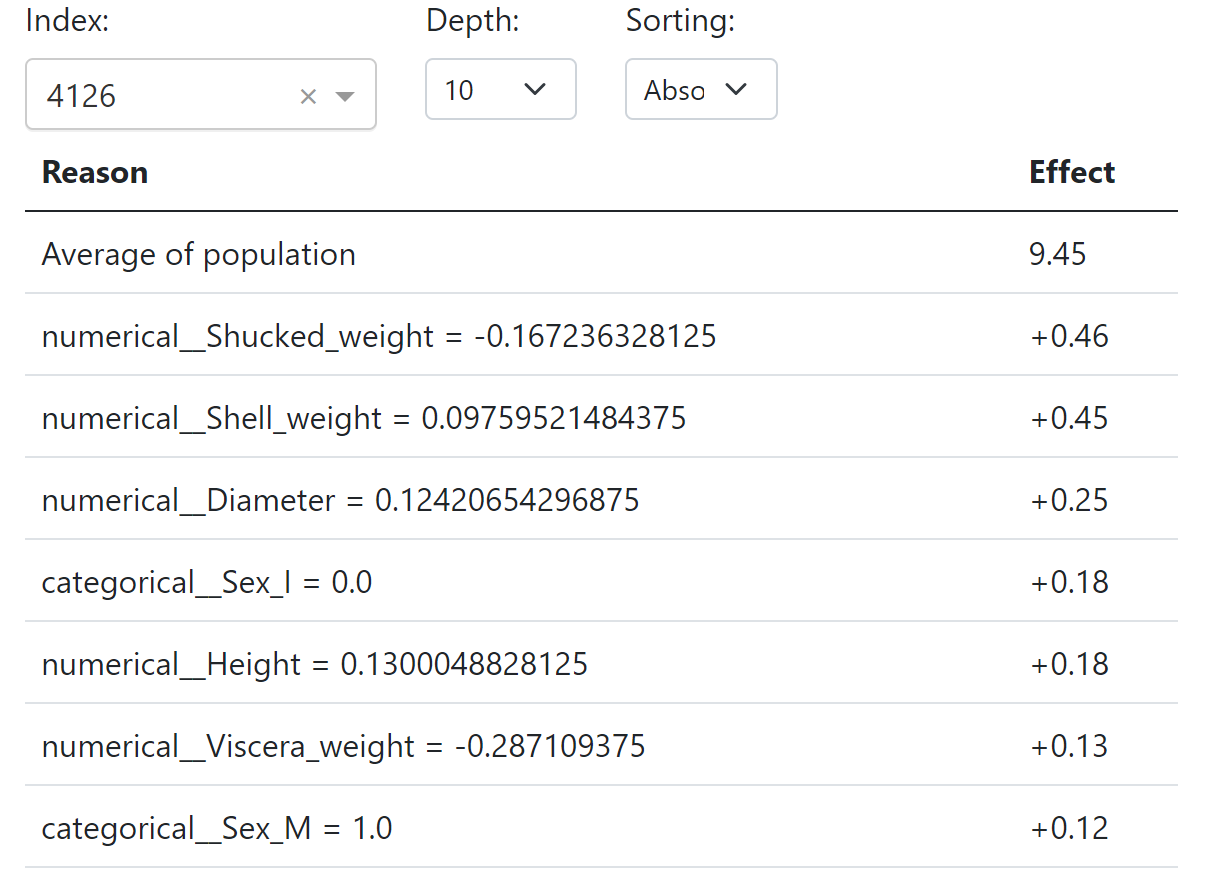

### 3820

Предсказанное значение - 10.837, реальное значение - 10.000. Расхождение - -0.837.



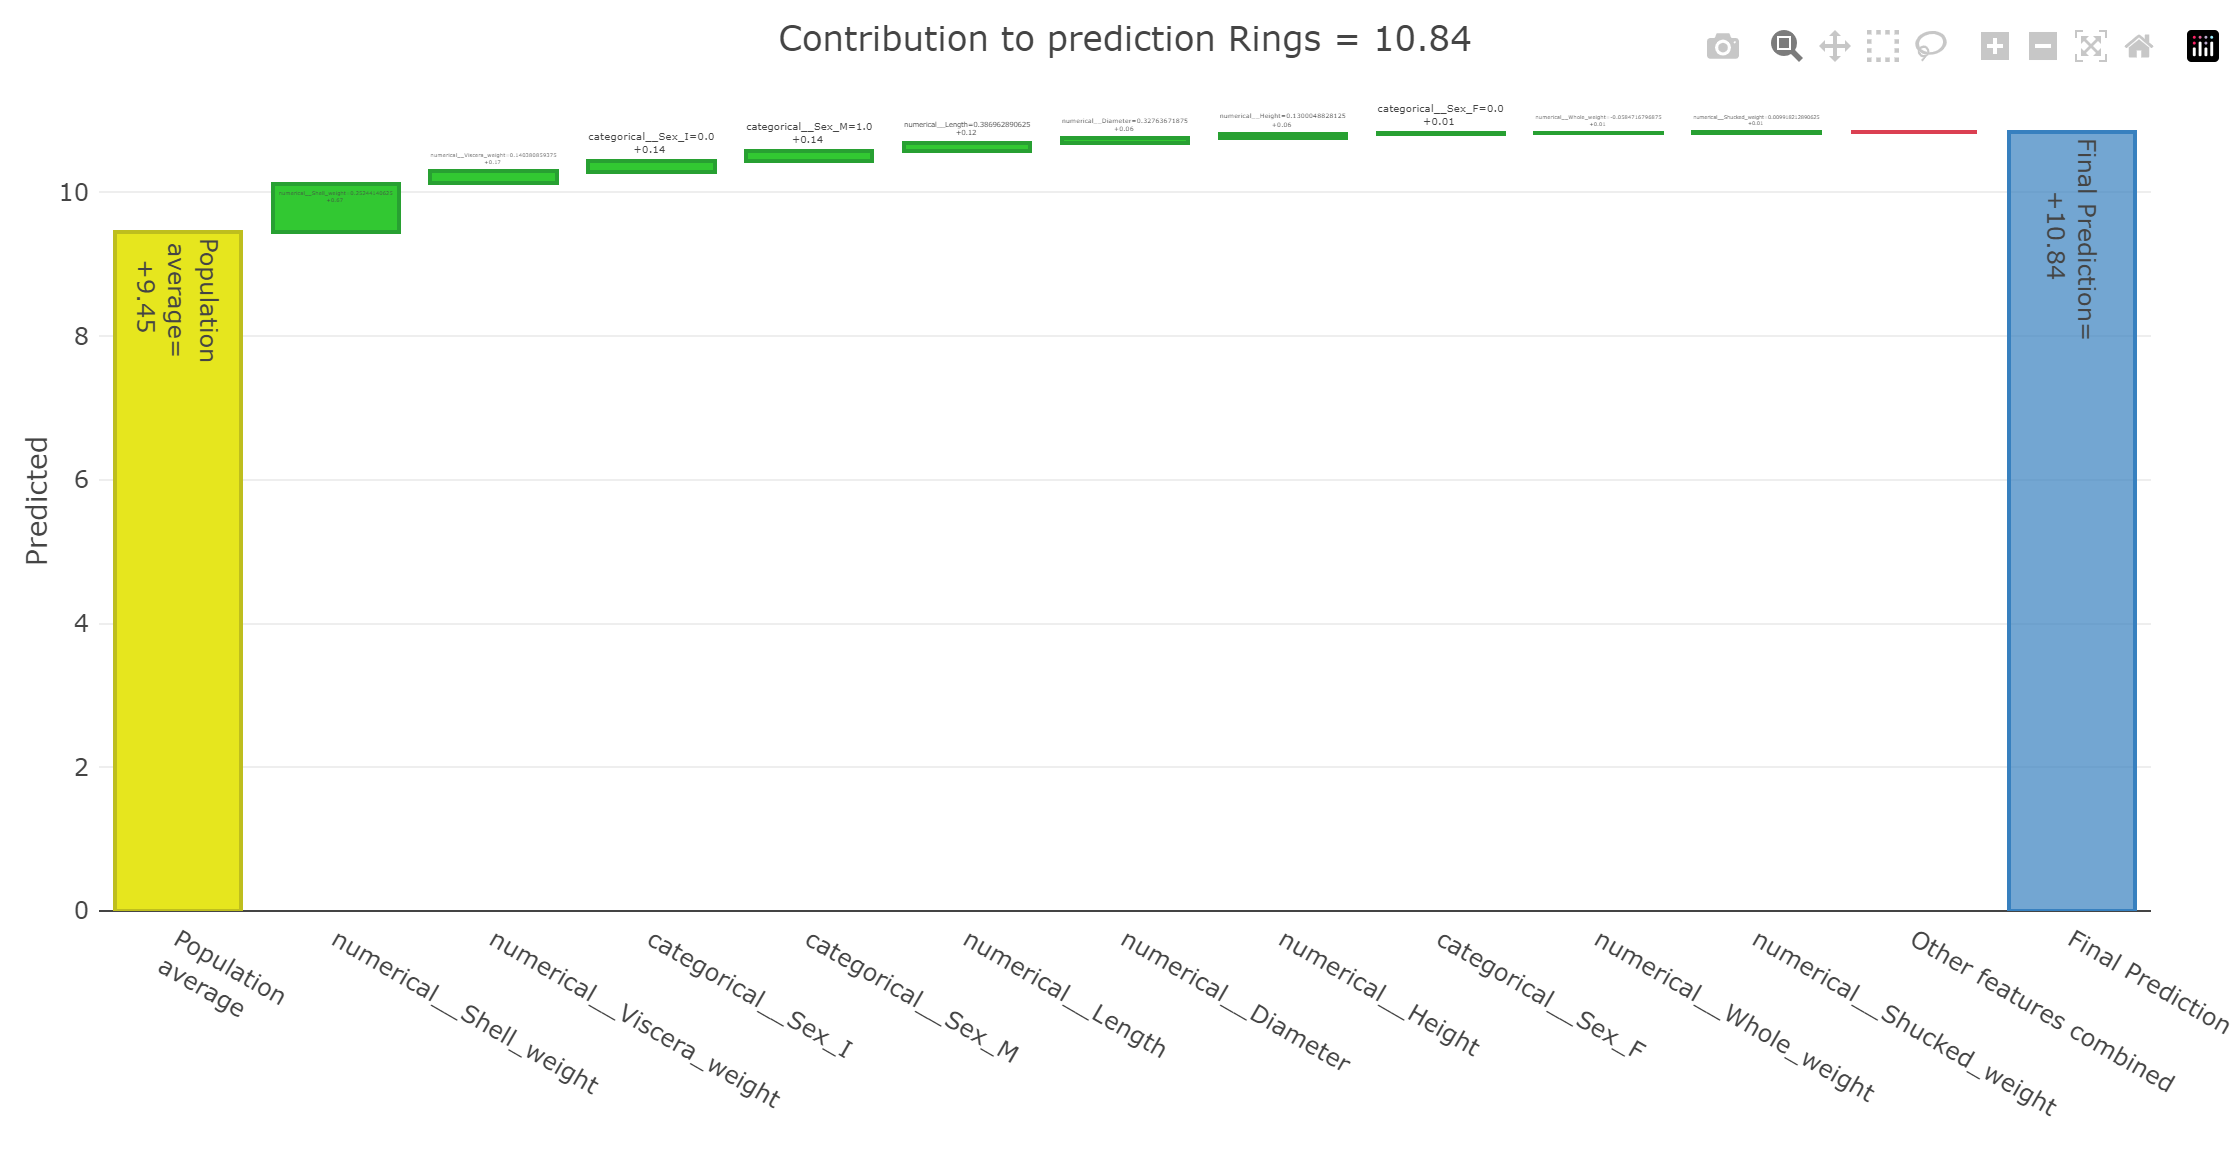

Важные признаки для данного объекта.

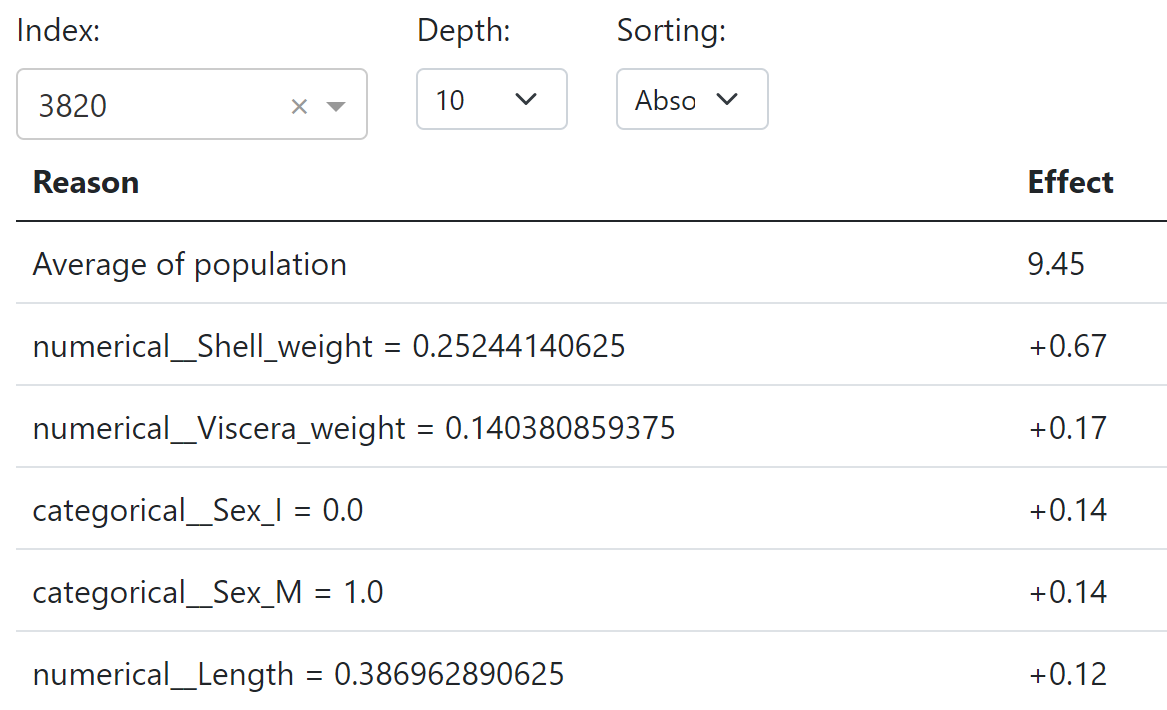

В принципе по всем трём несколько неясно как был выстроен финальный прогноз. Т.е.

In [45]:
db.terminate(8050)

Trying to shut down dashboard on port 8050...
